In [11]:
# create test and training data sets

import pandas as pd 
import numpy as np 
import random
import os

# decide upon the time period of interest for generating buy signals
# Assume you can sell at the lows and buy at highs for that day only
# Assume some transaction cost say 50 bps
def long_returns(df, numdays):
    df = df.copy()
#     df['buyret'] = (df.Low.shift(-numdays) / df.High - 1)*100
#     df['buyret'] = (df.low.shift(-numdays) / df.high - 1)*100
#     df['buyret'] = (df.close.shift(-numdays) / df.close - 1)*100
    df['buyret'] = (df.Close.shift(-numdays) / df.Close - 1)*100
    
    df.buyret.fillna(0, inplace=True)
    return df

# decide upon the time period of interest for generating sell signals
# Assume you can sell at the lows and buy at highs only
# Assume some transaction cost say 50 bps
def short_returns(df, numdays):
    df = df.copy()
#     df['sellret'] = (df.Low / df.High.shift(-numdays) -1)*100
#     df['sellret'] = (df.low / df.high.shift(-numdays) -1)*100
#     df['sellret'] = (df.close / df.close.shift(-numdays) -1)*100
    df['sellret'] = (df.Close / df.Close.shift(-numdays) -1)*100
    df.sellret.fillna(0,inplace=True)
    return df

def label_data(df):
    df = df.copy()
    df['Action'] = 'None'
    df.loc[df['buyret'] > 0.5, 'Action'] = 'Buy'
    df.loc[df['sellret'] > 0.5, 'Action'] = 'Sell'
#     df = df[df.columns.drop(['buyret','sellret'])]
    return df

# flexible function for computing moving average values
# normalise with variable that has the highest value
def moving_avg_data_normalised(df, mavnames, mavdays):
    df = df.copy()
    if(len(mavnames) != len(mavdays)):
        print('Variable Names and Number of days must match')
        return
    
    for i in range(0,len(mavnames)):
        df[mavnames[i]] = df.Close.rolling(window = mavdays[i]).mean()

    maxmovavg = mavnames[mavdays.index(max(mavdays))]
    mavnames.remove(maxmovavg)

    for i in range(0,len(mavnames)):
        df[mavnames[i]] = df[mavnames[i]] / df[maxmovavg]

    df.loc[:,maxmovavg] = 1
    df = df.drop(df.index[:max(mavdays)])
    return df

In [8]:
test = pd.read_csv('Data/csvdata_nonCryptos/AUDEUR=X.csv')

In [9]:
test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-01,0.60121,0.60827,0.60121,0.60798,0.60798,0.0
1,2003-12-02,0.60772,0.60901,0.60379,0.60551,0.60551,0.0
2,2003-12-03,0.60558,0.60887,0.60459,0.60764,0.60764,0.0
3,2003-12-04,0.60779,0.61002,0.60588,0.60838,0.60838,0.0
4,2003-12-05,0.60853,0.60872,0.60295,0.60419,0.60419,0.0
...,...,...,...,...,...,...,...
4281,2020-04-28,0.59583,0.59965,0.59430,0.59568,0.59568,0.0
4282,2020-04-29,0.60025,0.60294,0.59947,0.60019,0.60019,0.0
4283,2020-04-30,0.60237,0.60451,0.59606,0.60255,0.60255,0.0
4284,2020-05-01,0.59337,0.59337,0.58361,0.59338,0.59338,0.0


In [12]:
test2 = moving_avg_data_normalised(test, ['mavg20','mavg50'], [20, 50])
test2

,Date,Open,High,Low,Close,Adj Close,Volume,mavg20,mavg50
50,2004-02-09,0.60580,0.61256,0.60580,0.61151,0.61151,0.0,1.009930,1
51,2004-02-10,0.61185,0.61576,0.61050,0.61482,0.61482,0.0,1.010056,1
52,2004-02-11,0.61489,0.61527,0.61188,0.61323,0.61323,0.0,1.009999,1
53,2004-02-12,0.61338,0.61671,0.61248,0.61565,0.61565,0.0,1.010049,1
54,2004-02-13,0.61550,0.62073,0.61512,0.62050,0.62050,0.0,1.009928,1
...,...,...,...,...,...,...,...,...,...
4281,2020-04-28,0.59583,0.59965,0.59430,0.59568,0.59568,0.0,1.001684,1
4282,2020-04-29,0.60025,0.60294,0.59947,0.60019,0.60019,0.0,1.006177,1
4283,2020-04-30,0.60237,0.60451,0.59606,0.60255,0.60255,0.0,1.010762,1
4284,2020-05-01,0.59337,0.59337,0.58361,0.59338,0.59338,0.0,1.014458,1


In [13]:
os.listdir('Data/csvdata_nonCryptos')

['GC=F.csv',
 'GBPUSD=X.csv',
 'AUDUSD=X.csv',
 'CL=F.csv',
 'SI=F.csv',
 'AUDEUR=X.csv',
 'JPY=X.csv',
 'CHF=X.csv']

In [20]:
def create_datasets(csvfilename, sourceDir = 'Data/csvdata_nonCryptos', targetDir = 'Data/sampledata', fwdRet = 15):
    
    symbol = os.listdir(sourceDir)
    # now read each file and label the data as buy or sell
    # create the moving average days and names list to create the dataframe
    # number of days forward return you would like to predict

    data = pd.DataFrame()

    for i in range(0,len(symbol)):
        filename = sourceDir + '/' + symbol[i]
        temp = pd.read_csv(filename)
        temp['symbolid'] = symbol[i][:-4]
        temp = temp[['Date', 'symbolid', 'Open', 'High', 'Low', 'Close', 'Volume']]

        mavnames = ['mav5', 'mav10','mav20','mav30','mav50','mav100','mav200']
        mavdays = [5,10,20,30,50,100,200]

        temp = long_returns(temp, fwdRet)
        temp = short_returns(temp, fwdRet)
        temp = label_data(temp)
        temp = moving_avg_data_normalised(temp, mavnames, mavdays)
        temp = temp[['Date','symbolid','buyret','sellret','Action','mav5', 'mav10','mav20','mav30','mav50','mav100']]
        temp = temp.dropna()
        data = data.append(temp)

        #print(str(i/len(test_num)*100) + ' percent setup done')
    data.to_csv(targetDir + '/' +csvfilename)
    print(csvfilename + ' written to disk')
    return data

In [22]:
data = create_datasets('train_nonCryptos.csv')

train_nonCryptos.csv written to disk


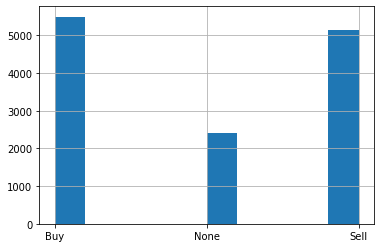

In [24]:
data['Action'].hist()